In [1]:
import pandas as pd
from random import*
import matplotlib.pylab as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
import tensorflow as tf
import keras
from keras.layers import Dense, LSTM, Input, RepeatVector
from keras.models import Sequential, Model
import seaborn as sns

In [2]:
! pip install torch

In [3]:
def random_value(data):
    data['gara1'] = 0
    
    for i in range(len(data)):
        if data['anomaly'][i] == 1:
            data['gara1'][i] = uniform(0.7, 1.0)
        else:
            data['gara1'][i] = uniform(0, 0.7)

    return data

In [4]:
def traffic_con(data):
    data['t_series'] = 0
    
    for i in range(len(data)):
        if data['anomaly'][i] == 1:
            data['count'][i] = randint(101, 1001)
        else:
            pass
    
    for i in range(len(data)):
        if data['count'][i] > 200:
            data['t_series'][i] = uniform(0.7, 1.0)
        else:
            data['gara1'][i] = uniform(0, 0.7)
    
    return data

In [5]:
def extract_col(data):
    df = data
    
    columns_to_keep = ['year', 'month', 'day', 'hour', 'minute', 'token_path', 'gara1', 't_series', 'anomaly']
#     columns_to_keep = ['token_path', 'anomaly', 'gara1', 't_series']
    anomaly_to_keep = ['anomaly']
    
    df = df[columns_to_keep]
    af = df['anomaly']
    
    return df, af

In [6]:
def draw_pattern(data, anomaly):
    x = data
    y = anomaly
    
    labels = np.unique(y)
    
    tsne = TSNE(n_components = 2, random_state = 0)
    X_embedded = tsne.fit_transform(x)
    
    for label in labels:
        mask = y == label
        if label == 0:
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label = 'Normal')
        else:
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label = 'Anomaly')
        
    plt.legend()
    plt.show()

In [7]:
def plus_data(data, anomaly):
    X = data
    y = anomaly
    
    smote = SMOTE(random_state = 0)
    
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    X_resampled = np.array(X_resampled)
    y_resampled = np.array(y_resampled)
    
    return X_resampled, y_resampled

In [8]:
def Autoencoder_gpu(data, y):
    X = data
    
    X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)
    
    with tf.device('/gpu:0'):
        input_layer = tf.keras.layers.Input(shape = (X.shape[1],))
        encoder = tf.keras.layers.Dense(64, activation = 'relu')(input_layer)
        encoder = tf.keras.layers.Dense(32, activation = 'relu')(encoder)
        encoder = tf.keras.layers.Dense(16, activation = 'relu')(encoder)
        decoder = tf.keras.layers.Dense(32, activation = 'relu')(encoder)
        decoder = tf.keras.layers.Dense(64, activation = 'relu')(decoder)
        output_layer = tf.keras.layers.Dense(X.shape[1], activation = 'linear')(decoder)
        autoencoder = tf.keras.models.Model(input_layer, output_layer)
        
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
        autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test))
        
        X_pred = autoencoder.predict(X_test)
        
        mse = np.mean((X_test - X_pred)**2, axis = 1)
        
        threshold = np.mean(mse) + 3 * np.std(mse)
        
        y_pred = (mse > threshold).astype(int)

        # Get the true labels for the test set
        y_true = data['anomaly'].iloc[X_test.index].values

        # Calculate the confusion matrix
        confusion_matrix = confusion_matrix(y_true, y_pred)
        
        sns.heatmap(confusion_matrix, annot=True, fmt='d')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix')
        plt.show()

In [9]:
def rogistic(data):
    X = data.drop(columns = ['anomaly']).values
    y = data['anomaly'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    with tf.device('/gpu:0'):
        model = LogisticRegression(random_state=0).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        plt.plot(['Accuracy'], [accuracy], 'ro')
        plt.xlabel('Metric')
        plt.ylabel('Score')
        plt.title('Accuracy Score')
        plt.show()
        
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues_r')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Compute AUC-ROC score
        auc = roc_auc_score(y_test, y_pred)
        
        # Compute false positive rate, true positive rate and thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

In [10]:
def one_svm(data):
    X = data.drop(columns = ['anomaly']).values
    y = data['anomaly'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    with tf.device('/gpu:0'):
        model = svm.OneClassSVM(kernel = 'linear', nu = 0.02).fit(X_train)
        
        y_pred = model.predict(X_test)
        
        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        
        scores = []
        
        for i in range(1, 101):
            model.fit(X_train)

            # Use the model to predict the labels for the test set
            y_pred = model.predict(X_test)

            # Convert the predictions to binary labels
            y_pred[y_pred == 1] = 0
            y_pred[y_pred == -1] = 1

            # Calculate the accuracy
            accuracy = accuracy_score(y_test, y_pred)
            scores.append(accuracy)

        # Plot the accuracy
        plt.plot(range(1, 101), scores)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Learning Process of Accuracy')
        plt.show()

        # Calculate the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Compute AUC-ROC score
        auc = roc_auc_score(y_test, y_pred)
        
        # Compute false positive rate, true positive rate and thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

In [11]:
def forest(data):
    X = data.drop(columns = ['anomaly']).values
    y = data['anomaly'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    with tf.device('/gpu:0'):
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
         
        # Calculate the confusion matrix and accuracy score
        cm = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        # Plot the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        print('Accuracy:', accuracy)
        
        # Compute AUC-ROC score
        auc = roc_auc_score(y_test, y_pred)
        
        # Compute false positive rate, true positive rate and thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

In [18]:
def ae(x, y):
    data = x.values
    ground_truth = y.values
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)

    # Build the autoencoder architecture
    
    train_data, test_data, train_gt, test_gt = train_test_split(data, ground_truth, test_size=0.2, random_state=42)

    # Normalize the training and testing data using StandardScaler
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    # Build the autoencoder architecture
    with tf.device('/gpu:0'):
        input_layer = Input(shape=(train_data.shape[1],))
        encoded = Dense(16, activation='relu')(input_layer)
        encoded = Dense(8, activation='relu')(encoded)
        decoded = Dense(16, activation='relu')(encoded)
        decoded = Dense(train_data.shape[1], activation='sigmoid')(decoded)
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        # Train the autoencoder on the normalized training data
        history = autoencoder.fit(train_data, train_data, epochs=100, batch_size=32, shuffle=True,
                         validation_data=(test_data, test_data))

        # Use the autoencoder to reconstruct the normalized test data and calculate the reconstruction error
        reconstructed_test_data = autoencoder.predict(test_data)
        reconstruction_error = np.mean(np.power(test_data - reconstructed_test_data, 2), axis=1)

        # Set a threshold for the reconstruction error to detect anomalies
        threshold = 3
        anomalies = np.where(reconstruction_error > threshold)[0]
        labels = np.zeros(test_data.shape[0])
        labels[anomalies] = 1

    # Calculate the confusion matrix and classification report
    conf_matrix = confusion_matrix(test_gt, labels)
    class_report = classification_report(test_gt, labels)
    fpr, tpr, thresholds = roc_curve(test_gt, reconstruction_error)
    auc = roc_auc_score(test_gt, reconstruction_error)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Data', 'Test Data'], loc='upper right')
    plt.show()

    # Plot the confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = 'Blues_r')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    

    # Print the classification report
    print("Classification Report:")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [13]:
data = pd.read_csv("preprocessing_bgp")

C:\Users\HanSol Park\AppData\Local\Temp\ipykernel_8256\3924448524.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gara1'][i] = uniform(0, 0.7)
C:\Users\HanSol Park\AppData\Local\Temp\ipykernel_8256\2914461033.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count'][i] = randint(101, 1001)
C:\Users\HanSol Park\AppData\Local\Temp\ipykernel_8256\2914461033.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['t_ser

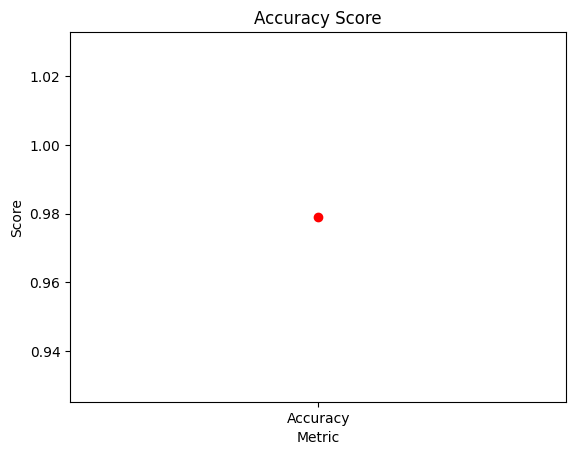

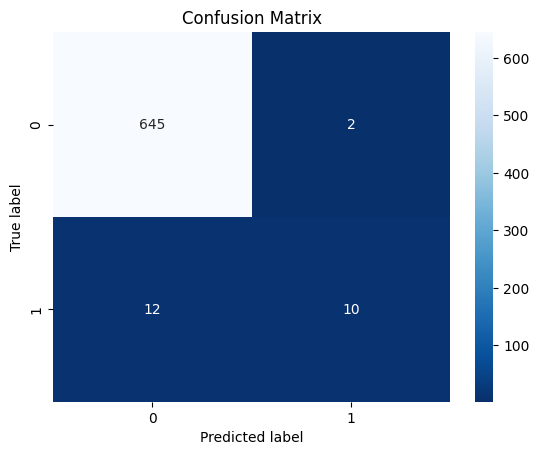

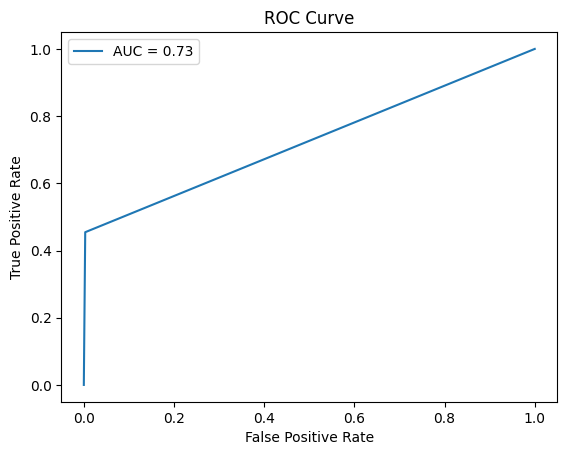

In [14]:
random_data = random_value(data)
time_data = traffic_con(random_data)
extra_data, anomaly_data = extract_col(time_data)
rogistic(extra_data)
# check_list = ['token_path', 'cnt_path', 'gara1', 't_series', 'anomaly']

# sample_data = time_data.loc[:, check_list]

# ts_data = tsne_data(sample_data, check_list)

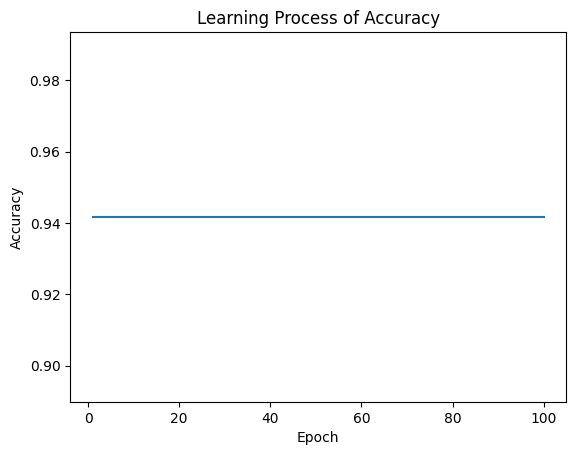

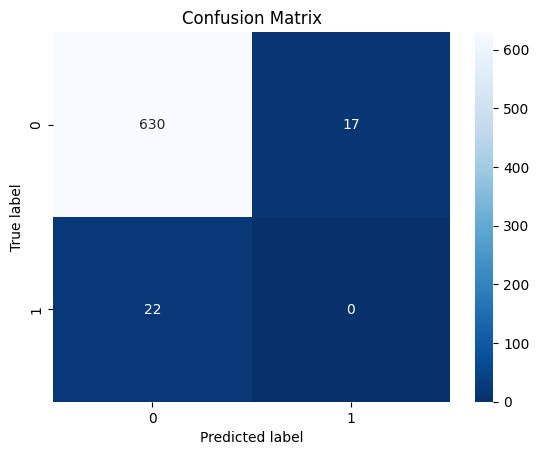

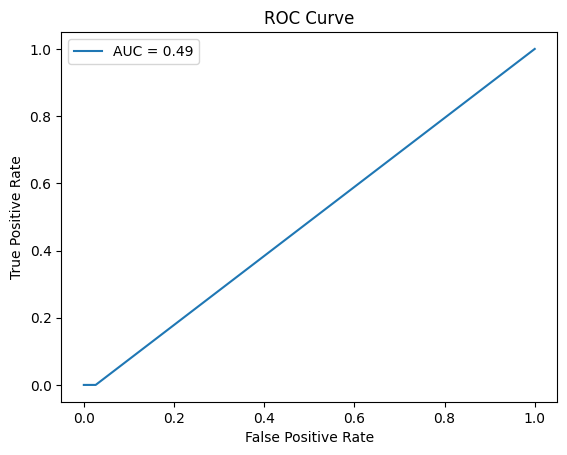

In [15]:
one_svm(extra_data)

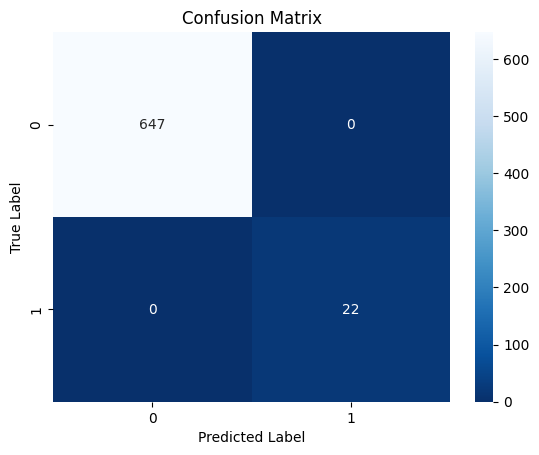

Accuracy: 1.0


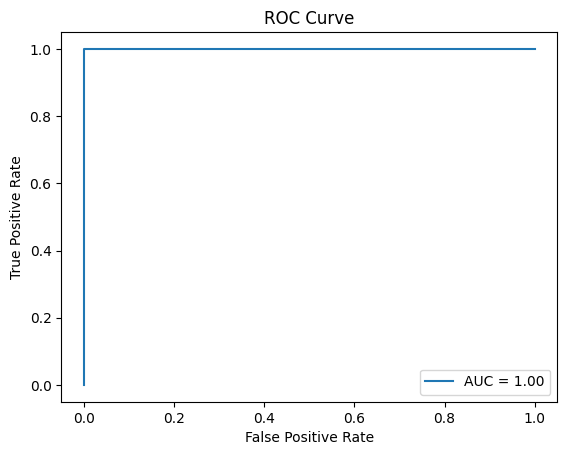

In [16]:
forest(extra_data)

Epoch 1/100
84/84 [==============================] - 0s 1ms/step - loss: 0.1214 - val_loss: 0.0801
Epoch 2/100
84/84 [==============================] - 0s 604us/step - loss: 0.0631 - val_loss: 0.0504
Epoch 3/100
84/84 [==============================] - 0s 610us/step - loss: 0.0475 - val_loss: 0.0394
Epoch 4/100
84/84 [==============================] - 0s 622us/step - loss: 0.0337 - val_loss: 0.0292
Epoch 5/100
84/84 [==============================] - 0s 605us/step - loss: 0.0240 - val_loss: 0.0215
Epoch 6/100
84/84 [==============================] - 0s 604us/step - loss: 0.0178 - val_loss: 0.0174
Epoch 7/100
84/84 [==============================] - 0s 622us/step - loss: 0.0150 - val_loss: 0.0152
Epoch 8/100
84/84 [==============================] - 0s 598us/step - loss: 0.0133 - val_loss: 0.0135
Epoch 9/100
84/84 [==============================] - 0s 598us/step - loss: 0.0117 - val_loss: 0.0120
Epoch 10/100
84/84 [==============================] - 0s 616us/step - loss: 0.0101 - val_loss

84/84 [==============================] - 0s 610us/step - loss: 6.3372e-04 - val_loss: 6.4100e-04
Epoch 79/100
84/84 [==============================] - 0s 596us/step - loss: 6.3400e-04 - val_loss: 6.2736e-04
Epoch 80/100
84/84 [==============================] - 0s 592us/step - loss: 6.2523e-04 - val_loss: 6.1474e-04
Epoch 81/100
84/84 [==============================] - 0s 604us/step - loss: 6.1142e-04 - val_loss: 6.1532e-04
Epoch 82/100
84/84 [==============================] - 0s 598us/step - loss: 6.1767e-04 - val_loss: 6.1764e-04
Epoch 83/100
84/84 [==============================] - 0s 596us/step - loss: 6.1551e-04 - val_loss: 6.2477e-04
Epoch 84/100
84/84 [==============================] - 0s 586us/step - loss: 6.0639e-04 - val_loss: 6.0939e-04
Epoch 85/100
84/84 [==============================] - 0s 605us/step - loss: 6.0921e-04 - val_loss: 6.3596e-04
Epoch 86/100
84/84 [==============================] - 0s 603us/step - loss: 6.0882e-04 - val_loss: 5.8893e-04
Epoch 87/100
84/84 [===

C:\Users\HanSol Park\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HanSol Park\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HanSol Park\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

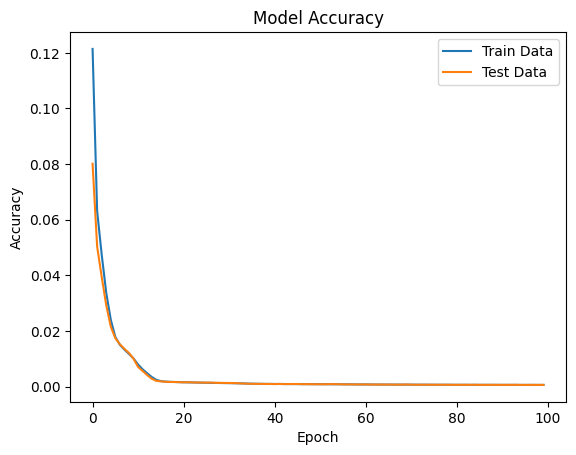

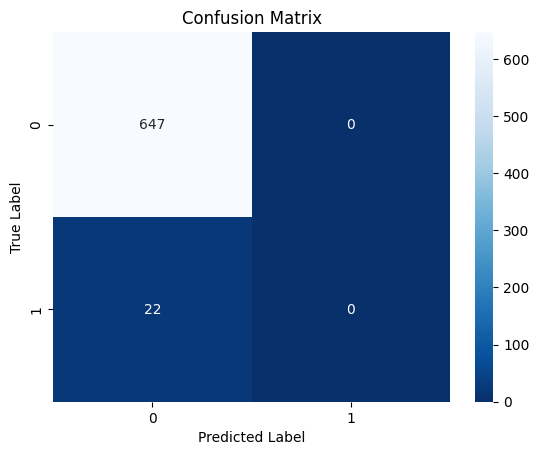

Classification Report:


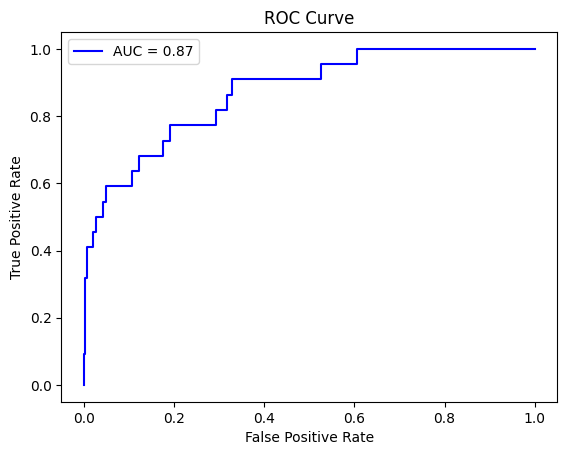

In [19]:
ae(extra_data, anomaly_data)